# Experimentación - MPNN_LSTM 



## 1. Obtención de datos



In [1]:

import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np


import itertools
import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid


from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch

from utils.models import MPNNLSTMModel
from utils.trainer import  TrainerMPNNLSTM
from utils.utils_graph import *
dtype = torch.float
device = torch.device("cpu")

In [2]:
from importlib import reload
import utils.models
utils.models = reload(utils.models)
from utils.models import MPNNLSTMModel

In [3]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [4]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="classification_type")
_,_,_ =loader.process()
limit = 300
dataset_full, situations_each = loader.get_dataset()
target_names = loader.target_names

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [5]:
def entrenar_y_evaluar_modelos_mpnnlstm(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem="Classification", name=None, target_names=None):
    resultados_list = []

    # Variables para guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None

    # Detalles del dataset
    n_nodes = dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[0]
    n_features = dataset[0].x.shape[1]

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    for hidden_size, dropout in tqdm(list(itertools.product(param_grid["hidden_size"], param_grid["dropout"]))):
        model = MPNNLSTMModel(name=name or "MPNN_LSTM", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=hidden_size, window=1, dropout=dropout, is_classification=True)
        trainer = TrainerMPNNLSTM(model, dataset, device, f"../experimentos_split/results/{problem}", dataloader_params, is_classification = True)

        losses, eval_losses, accs, precisions, recalls, f1s = trainer.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
        test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = trainer.test()

        results_intermedio = {
            "Hidden Size": hidden_size,
            "Dropout": dropout,
            "Loss_final": losses[-1],  # Usando el último valor de la lista, si es consistente con tus datos
            "Accuracy_eval": np.mean(accs),
            "Precision_eval": np.mean(precisions),
            "Recall_eval": np.mean(recalls),
            "F1_eval": np.mean(f1s),
            "Loss_eval": np.mean(eval_losses[-1]),  # Asumiendo que tienes evaluaciones periódicas como en regresión
            "Loss_tst": np.mean(test_loss),
            "Accuracy_tst": test_acc,
            "Precision_tst": test_precision,
            "Recall_tst": test_recall,
            "F1_tst": test_f1
        }
        
        resultados_list.append(results_intermedio)

        # Actualizar el mejor modelo si es necesario
        if np.mean(test_loss) < mejor_loss_test:
            mejor_loss_test = np.mean(test_loss)
            mejor_trainer = trainer
            mejores_parametros = {'Hidden Size': hidden_size, 'Dropout': dropout}
            mejores_resultados = results_intermedio

        print("Parámetros: ", hidden_size, dropout)
        print("Resultados: ", resultados_list[-1])

    resultados_df = pd.DataFrame(resultados_list)
    return mejor_trainer, mejores_parametros, mejores_resultados, resultados_df


## Bucle rápido para ajustar y guardar resultados

In [6]:
from importlib import reload
import utils.models
utils.models = reload(utils.models)
from utils.models import MPNNLSTMModel

In [7]:

param_grid = {
    "hidden_size": [16, 32, 64],
    "dropout": [0.2, 0.5, 0.8]
}

dataloader_params = {
    "batch_size": 32,
    "data_split_ratio": [0.7, 0.15, 0.15],
    "seed": 42,
    "keep_same": True,
    "use_batch": False
}

num_early_stop = 10
num_epochs = 100
problem = "clasificacion"

mejor_trainer, mejores_parametros, mejores_resultados, resultados_df = entrenar_y_evaluar_modelos_mpnnlstm(
    param_grid, 
    dataset_full, 
    dataloader_params, 
    num_early_stop, 
    num_epochs, 
    problem, "MPNN_LSTM",target_names)

  0%|          | 0/9 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 390
Validation dataset: 75
Test dataset: 84

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 1.5526 | Eval Loss: 1.4824 | Accuracy: 0.3867 | Precision: 0.0773 | Recall: 0.2000 | F1-Score: 0.1115 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 1.5150 | Eval Loss: 1.4552 | Accuracy: 0.4533 | Precision: 0.3706 | Recall: 0.2771 | F1-Score: 0.2278 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 1.4855 | Eval Loss: 1.4136 | Accuracy: 0.4800 | Precision: 0.4752 | Recall: 0.3057 | F1-Score: 0.2673 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 1.4630 | Eval Loss: 1.4100 | Accuracy: 0.5467 | Precision: 0.3817 | Recall: 0.4148 | F1-Score: 0.3727 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 1.4437 | Eval Loss: 1.3851 | Accuracy: 0.5333 | Precision: 0.2893 | Recall: 0.3891 | F1-Score: 0.3284 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 1.4280 | Eval Loss: 1.3789 | Accuracy: 0.5333 | Precision: 0.2949 | Recall: 0.4153 | 

 11%|█         | 1/9 [05:13<41:46, 313.34s/it]

              precision    recall  f1-score   support

           0       0.57      0.67      0.62        12
           1       0.34      0.73      0.47        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.66      0.79      0.72        29

    accuracy                           0.50        84
   macro avg       0.31      0.44      0.36        84
weighted avg       0.37      0.50      0.42        84

preds:  torch.Size([])
test loss: 1.377121, test accuracy: 0.5000, test precision: 0.3145, test recall: 0.4386, test F1-score: 0.3604
Parámetros:  16 0.2
Resultados:  {'Hidden Size': 16, 'Dropout': 0.2, 'Loss_final': 1.2861946821212769, 'Accuracy_eval': 0.582051282051282, 'Precision_eval': 0.39770292606386776, 'Recall_eval': 0.4736566881394468, 'F1_eval': 0.4001820135299375, 'Loss_eval': 1.3052695989608765, 'Loss_tst': 1.3771212100982666, 'Accuracy_tst': 0.5, 'Precision_tst': 0.31446428571428575, 'Recall_t

 22%|██▏       | 2/9 [10:30<36:49, 315.69s/it]

              precision    recall  f1-score   support

           0       0.57      0.67      0.62        12
           1       0.34      0.73      0.47        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.66      0.79      0.72        29

    accuracy                           0.50        84
   macro avg       0.31      0.44      0.36        84
weighted avg       0.37      0.50      0.42        84

preds:  torch.Size([])
test loss: 1.379340, test accuracy: 0.5000, test precision: 0.3145, test recall: 0.4386, test F1-score: 0.3604
Parámetros:  16 0.5
Resultados:  {'Hidden Size': 16, 'Dropout': 0.5, 'Loss_final': 1.2873022556304932, 'Accuracy_eval': 0.5787179487179487, 'Precision_eval': 0.38865010820181695, 'Recall_eval': 0.47047934823796894, 'F1_eval': 0.3990547814892873, 'Loss_eval': 1.3051143884658813, 'Loss_tst': 1.3793398141860962, 'Accuracy_tst': 0.5, 'Precision_tst': 0.31446428571428575, 'Recall

 33%|███▎      | 3/9 [15:43<31:25, 314.31s/it]

              precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.33      0.73      0.46        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.70      0.79      0.74        29

    accuracy                           0.51        84
   macro avg       0.33      0.46      0.37        84
weighted avg       0.39      0.51      0.43        84

preds:  torch.Size([])
test loss: 1.380532, test accuracy: 0.5119, test precision: 0.3261, test recall: 0.4553, test F1-score: 0.3734
Parámetros:  16 0.8
Resultados:  {'Hidden Size': 16, 'Dropout': 0.8, 'Loss_final': 1.287752389907837, 'Accuracy_eval': 0.5805128205128205, 'Precision_eval': 0.39362477320437106, 'Recall_eval': 0.4724024251610459, 'F1_eval': 0.399802531850376, 'Loss_eval': 1.306607961654663, 'Loss_tst': 1.3805320262908936, 'Accuracy_tst': 0.5119047619047619, 'Precision_tst': 0.326060606060606

 44%|████▍     | 4/9 [20:59<26:15, 315.12s/it]

              precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.00      0.00      0.00        15
           2       0.25      0.11      0.15         9
           3       0.00      0.00      0.00        19
           4       0.44      1.00      0.61        29

    accuracy                           0.46        84
   macro avg       0.27      0.37      0.29        84
weighted avg       0.27      0.46      0.33        84

preds:  torch.Size([])
test loss: 1.426557, test accuracy: 0.4643, test precision: 0.2665, test recall: 0.3722, test F1-score: 0.2913
Parámetros:  32 0.2
Resultados:  {'Hidden Size': 32, 'Dropout': 0.2, 'Loss_final': 1.376481294631958, 'Accuracy_eval': 0.5461538461538462, 'Precision_eval': 0.2817128845769279, 'Recall_eval': 0.3708791208791208, 'F1_eval': 0.29537716004129044, 'Loss_eval': 1.339723825454712, 'Loss_tst': 1.4265565872192383, 'Accuracy_tst': 0.4642857142857143, 'Precision_tst': 0.26645021645021

 56%|█████▌    | 5/9 [26:20<21:09, 317.30s/it]

              precision    recall  f1-score   support

           0       0.62      0.67      0.64        12
           1       0.00      0.00      0.00        15
           2       0.20      0.11      0.14         9
           3       0.00      0.00      0.00        19
           4       0.44      1.00      0.61        29

    accuracy                           0.45        84
   macro avg       0.25      0.36      0.28        84
weighted avg       0.26      0.45      0.32        84

preds:  torch.Size([])
test loss: 1.426139, test accuracy: 0.4524, test precision: 0.2510, test recall: 0.3556, test F1-score: 0.2787
Parámetros:  32 0.5
Resultados:  {'Hidden Size': 32, 'Dropout': 0.5, 'Loss_final': 1.3763562440872192, 'Accuracy_eval': 0.5471794871794873, 'Precision_eval': 0.28237319758074403, 'Recall_eval': 0.3719780219780219, 'F1_eval': 0.29564183958149104, 'Loss_eval': 1.3394801616668701, 'Loss_tst': 1.426139235496521, 'Accuracy_tst': 0.4523809523809524, 'Precision_tst': 0.250955710955

 67%|██████▋   | 6/9 [31:40<15:53, 317.97s/it]

              precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.44      1.00      0.61        29

    accuracy                           0.45        84
   macro avg       0.21      0.35      0.26        84
weighted avg       0.24      0.45      0.31        84

preds:  torch.Size([])
test loss: 1.425201, test accuracy: 0.4524, test precision: 0.2079, test recall: 0.3500, test F1-score: 0.2554
Parámetros:  32 0.8
Resultados:  {'Hidden Size': 32, 'Dropout': 0.8, 'Loss_final': 1.3766039609909058, 'Accuracy_eval': 0.5479487179487179, 'Precision_eval': 0.2818400044311826, 'Recall_eval': 0.3728021978021978, 'F1_eval': 0.2949719724425053, 'Loss_eval': 1.3404123783111572, 'Loss_tst': 1.4252012968063354, 'Accuracy_tst': 0.4523809523809524, 'Precision_tst': 0.2078787878787

 78%|███████▊  | 7/9 [36:57<10:35, 317.85s/it]

              precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.36      0.80      0.50        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.73      0.83      0.77        29

    accuracy                           0.54        84
   macro avg       0.34      0.48      0.39        84
weighted avg       0.40      0.54      0.45        84

preds:  torch.Size([])
test loss: 1.348738, test accuracy: 0.5357, test precision: 0.3382, test recall: 0.4755, test F1-score: 0.3882
Parámetros:  64 0.2
Resultados:  {'Hidden Size': 64, 'Dropout': 0.2, 'Loss_final': 1.270142912864685, 'Accuracy_eval': 0.5833333333333335, 'Precision_eval': 0.3911491083324503, 'Recall_eval': 0.47481053429329295, 'F1_eval': 0.3999533317098569, 'Loss_eval': 1.2868552207946777, 'Loss_tst': 1.3487375974655151, 'Accuracy_tst': 0.5357142857142857, 'Precision_tst': 0.3381818181818

 89%|████████▉ | 8/9 [42:15<05:17, 317.77s/it]

              precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.33      0.73      0.46        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.70      0.79      0.74        29

    accuracy                           0.51        84
   macro avg       0.33      0.46      0.37        84
weighted avg       0.39      0.51      0.43        84

preds:  torch.Size([])
test loss: 1.372802, test accuracy: 0.5119, test precision: 0.3261, test recall: 0.4553, test F1-score: 0.3734
Parámetros:  64 0.5
Resultados:  {'Hidden Size': 64, 'Dropout': 0.5, 'Loss_final': 1.2832876443862915, 'Accuracy_eval': 0.5800000000000002, 'Precision_eval': 0.3840834484352885, 'Recall_eval': 0.47166540356195547, 'F1_eval': 0.39409345734047374, 'Loss_eval': 1.3003194332122803, 'Loss_tst': 1.3728017807006836, 'Accuracy_tst': 0.5119047619047619, 'Precision_tst': 0.32606060606

100%|██████████| 9/9 [47:32<00:00, 316.90s/it]

              precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.33      0.73      0.46        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.70      0.79      0.74        29

    accuracy                           0.51        84
   macro avg       0.33      0.46      0.37        84
weighted avg       0.39      0.51      0.43        84

preds:  torch.Size([])
test loss: 1.373987, test accuracy: 0.5119, test precision: 0.3261, test recall: 0.4553, test F1-score: 0.3734
Parámetros:  64 0.8
Resultados:  {'Hidden Size': 64, 'Dropout': 0.8, 'Loss_final': 1.2831082344055176, 'Accuracy_eval': 0.5810256410256411, 'Precision_eval': 0.38537117485603056, 'Recall_eval': 0.4728741947707466, 'F1_eval': 0.3932282222133591, 'Loss_eval': 1.3010642528533936, 'Loss_tst': 1.3739874362945557, 'Accuracy_tst': 0.5119047619047619, 'Precision_tst': 0.326060606060


==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.34      0.73      0.47        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.52        84
   macro avg       0.33      0.46      0.38        84
weighted avg       0.39      0.52      0.44        84

preds:  torch.Size([])
test loss: 1.356322, test accuracy: 0.5238, test precision: 0.3299, test recall: 0.4622, test F1-score: 0.3793


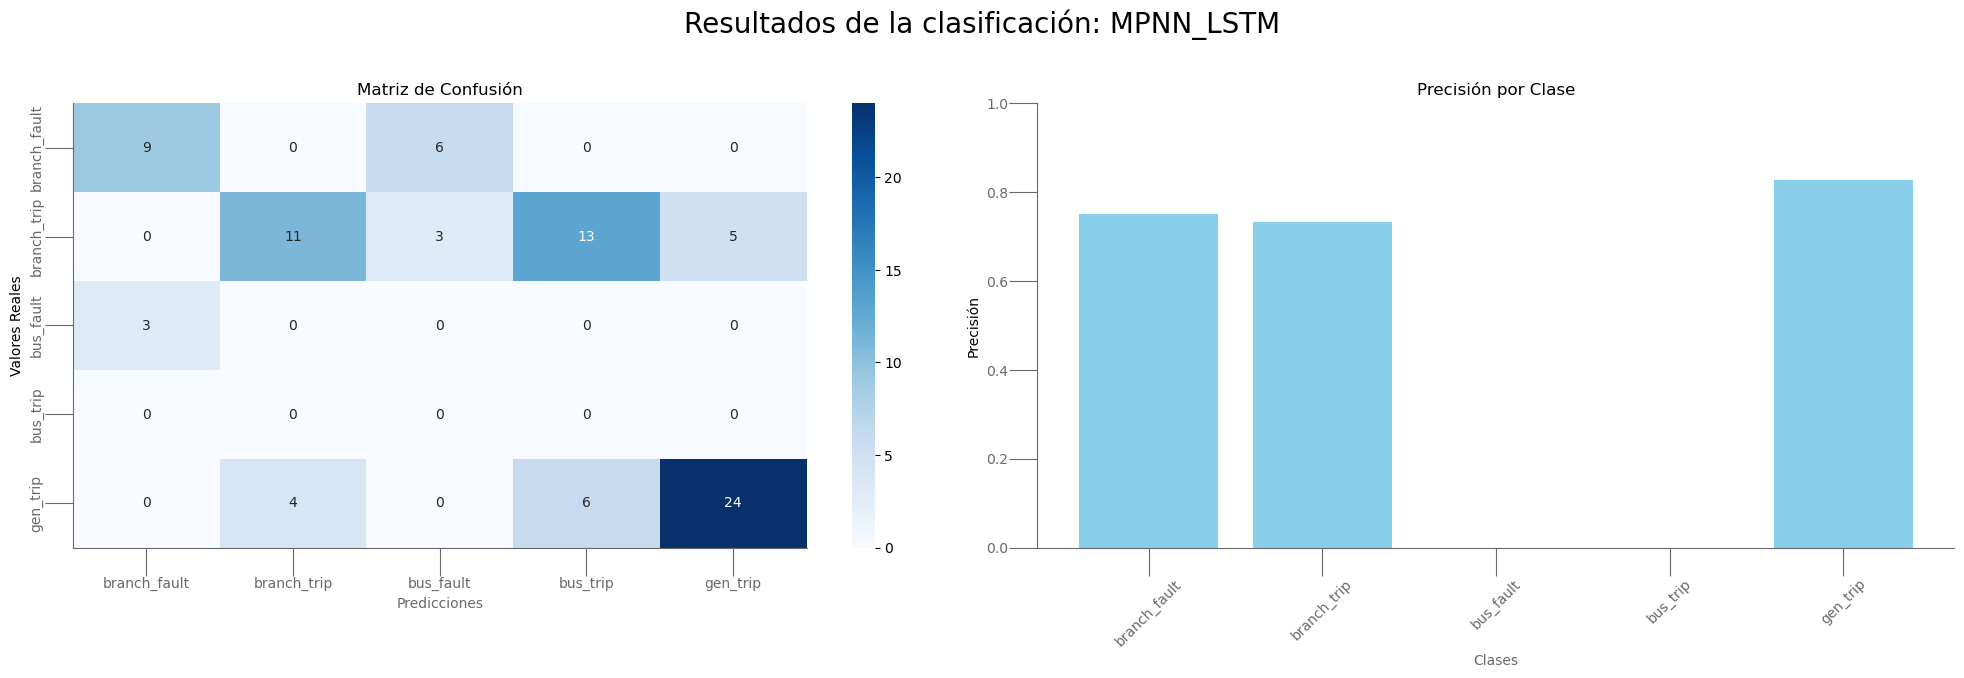

In [9]:
test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = mejor_trainer.test()
plot_clasificacion(real, preds, target_names, "MPNN_LSTM")

In [8]:
name_model ="MPNN_LSTM"
results_save_path = "../experimentos_split/results"

path_save_experiment = results_save_path+f"/{problem}"+ f"/ajustes/{name_model}_results.csv"
resultados_df.to_csv(path_save_experiment, index=False)
mejor_trainer.save_model(path_save_experiment=path_save_experiment, params = mejores_parametros)


==================== GUARDANDO RESULTADOS ===================

         Modelo                               Params  \
0    LSTM_BATCH    {'Hidden Size': 150, 'Layers': 1}   
1  LSTM_NOBATCH    {'Hidden Size': 150, 'Layers': 1}   
2     MPNN_LSTM  {'Hidden Size': 64, 'Dropout': 0.2}   

                      Fichero_resultados_experimento  Loss_tst  Loss_eval  \
0  ../experimentos_split/results/clasificacion/aj...  1.159883   1.177060   
1  ../experimentos_split/results/clasificacion/aj...  1.163815   1.189499   
2  ../experimentos_split/results/clasificacion/aj...  1.348738   1.286855   

   Loss_final  Accuracy_eval  Precision_eval  Recall_eval   F1_eval  \
0    1.053747       0.718750        0.682540     0.713932  0.674393   
1    1.119299       0.706667        0.677778     0.660493  0.660158   
2    1.270143       0.600000        0.438630     0.498128  0.435153   

   Accuracy_tst  Precision_tst  Recall_tst    F1_tst  
0      0.750000       0.681212    0.673016  0.675524  
1      